# Artificial Intelligence Course - Fall 1402
## Computer Assignment #3 - Hidden Markov Model (HMM)

### Mehdi Jamalkhah, SID: 810100111

### Table of Contents<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Data Set](#toc2_)    
- [Preprocessing and Feature Extraction](#toc3_)    
  - [Preprocessing](#toc3_1_)    
  - [Feature Extraction](#toc3_2_)    
  - [Train Test Split](#toc3_3_)    
- [Modeling by Use of HMM](#toc4_)    
  - [First Order HMM](#toc4_1_)    
  - [Applications and Use Cases of HMMs](#toc4_2_)    
  - [Advantages and Disadvantages](#toc4_3_)    
  - [Different Types of HMM](#toc4_4_)    
- [Implementation](#toc5_)    
  - [Implementing with Libraries](#toc5_1_)    
  - [Implementing from Scratch](#toc5_2_)    
- [Evaluation](#toc6_)    
  - [Classification Quality Metrics](#toc6_1_)    
    - [Accuracy](#toc6_1_1_)    
    - [Percision](#toc6_1_2_)    
    - [Recall](#toc6_1_3_)    
    - [F1 Score](#toc6_1_4_)    
  - [Averaging](#toc6_2_)    
    - [Macro-averaging](#toc6_2_1_)    
    - [Micro-averaging](#toc6_2_2_)    
    - [Weighted-averaging](#toc6_2_3_)    
- [View Results](#toc7_)    
- [Compare Results](#toc8_)    
- [Refrences](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<a name='0'></a>
## <a id='toc1_'></a>Introduction [](#toc0_)
In this project, we will explore the application of the Hidden Markov Model (HMM) in the context of music genre classification. Our dataset comprises four music genres, each with 100 audio files. Initially, we will preprocess the dataset and extract its features. In the first section, we will utilize the hmmlearn library to construct the model. Moving to the second section, our focus will shift to coding the HMM from scratch. Finally, we will evaluate both models using various criteria.

In [1]:
# Import
import numpy as np
import os
import librosa
from math import floor
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

<a name='1'></a>
## <a id='toc2_'></a>Data Set [](#toc0_)
We have access to a dataset comprising four distinct music genres, namely blues, pop, metal, and hip-hop, with each genre containing 100 audio files. Our initial step involves reading and saving these audio files.

In [4]:
# Read audios
root_folder = 'data'
num_genres = 4
num_files_per_genre = 100
genre_names = np.array([])
audio_data = np.empty((num_genres * num_files_per_genre, ), dtype=object)
audio_count = 0

for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)

    if os.path.isdir(folder_path):
        genre_names = np.append(genre_names, folder_name)
        for audio_file in os.listdir(folder_path):
            audio_path = os.path.join(folder_path, audio_file)

            if audio_file.endswith('.wav'):
                data, sr = librosa.load(audio_path)
                audio_data[audio_count] = data[0:(data.shape[0] // sr) * sr]
                audio_count += 1

print("Number of audios are ",audio_count)

Number of audios are  400


<a name='2'></a>
## <a id='toc3_'></a>Preprocessing and Feature Extraction [](#toc0_)
Certainly, to build an effective dataset for training our model, it's essential to undergo preprocessing steps and extract pertinent features from each audio file. These steps contribute to enhancing the quality and effectiveness of the training process.


<a name='2-1'></a>
### <a id='toc3_1_'></a>Preprocessing [](#toc0_)
We will segment each audio to the same length. This can be beneficial and may lead to better results for several reasons:
- **Localized Analysis**: Segmenting the data allows for localized analysis of specific parts of the dataset. Instead of considering the entire dataset as a whole, we can focus on individual segments, which may contain distinct patterns or behaviors. This local features can be lost when combining with other features in the entire dataset.

- **Handling Variable-Length Samples**: In some cases, the length of the input data may vary. By segmenting the data into fixed-length segments, we can standardize the samples size. sometimes the feature that we extract is realated to the length of the sample and if we had variable-length samples, is possible that get diffrent value of a same feature for two samples, which can decrease the accuracy of our model.

- **Reducing Computational Complexity**: When the time complexity is greater than linear, which is often the case, splitting the data can help reduce the overall time complexity.

In [5]:
# Segmentation
audio_data_seg = np.empty((num_genres, ), dtype=object)
audio_count = np.empty((num_genres, ), np.int32)
for i in range(num_genres):
    data = np.concatenate(audio_data[i * num_files_per_genre: (i + 1) * num_files_per_genre].flatten())
    audio_data_seg[i] = np.array(np.split(data, data.shape[0] // sr))
    print('{:s}: {:d} samples'.format(genre_names[i],audio_data_seg[i].shape[0]))
    audio_count[i] = audio_data_seg[i].shape[0]


blues: 3000 samples
hiphop: 2998 samples
metal: 3000 samples
pop: 3000 samples


<a name='2-2'></a>
### <a id='toc3_2_'></a>Feature Extraction [](#toc0_)
In this project, we use Mel-Frequency Cepstral Coefficients (MFCC) as a feature to characterize each audio.

In [6]:
# Create MFCC
audio_mfcc = np.array([np.empty((size,), dtype=object) for size in audio_count], dtype=object)
for i in range(num_genres):
    for j in range(audio_count[i]):
        audio_mfcc[i][j] = librosa.feature.mfcc(y=audio_data_seg[i][j], n_mfcc=13, sr=sr)

Let's plot the MFCC of one sample from each genre.

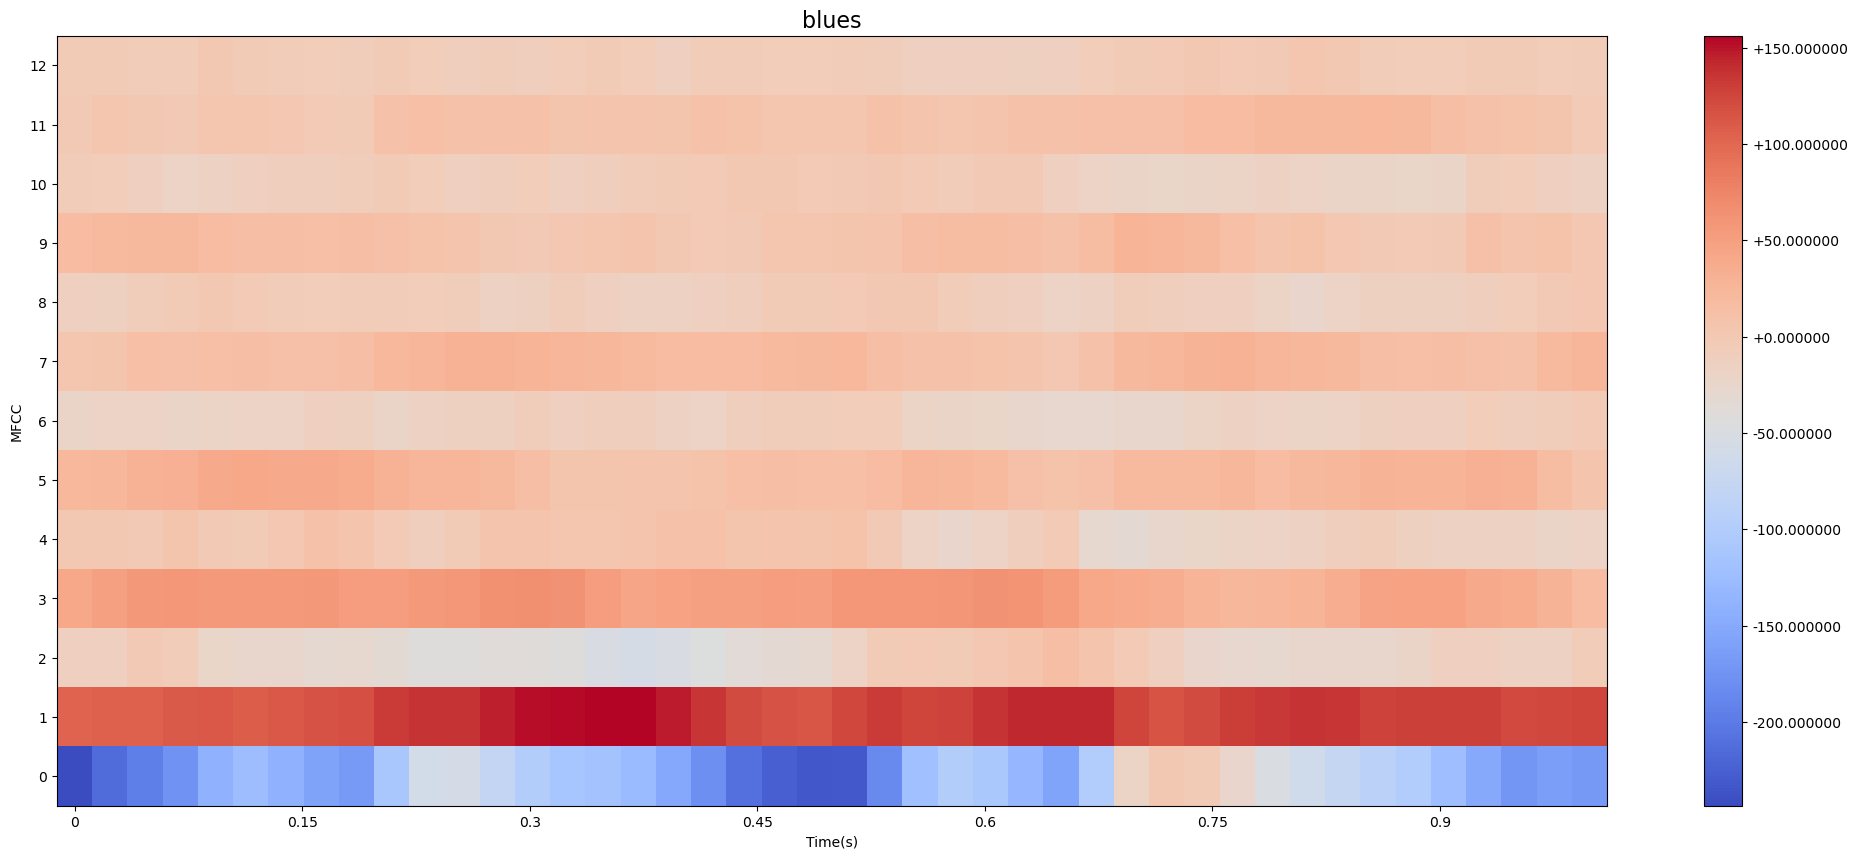

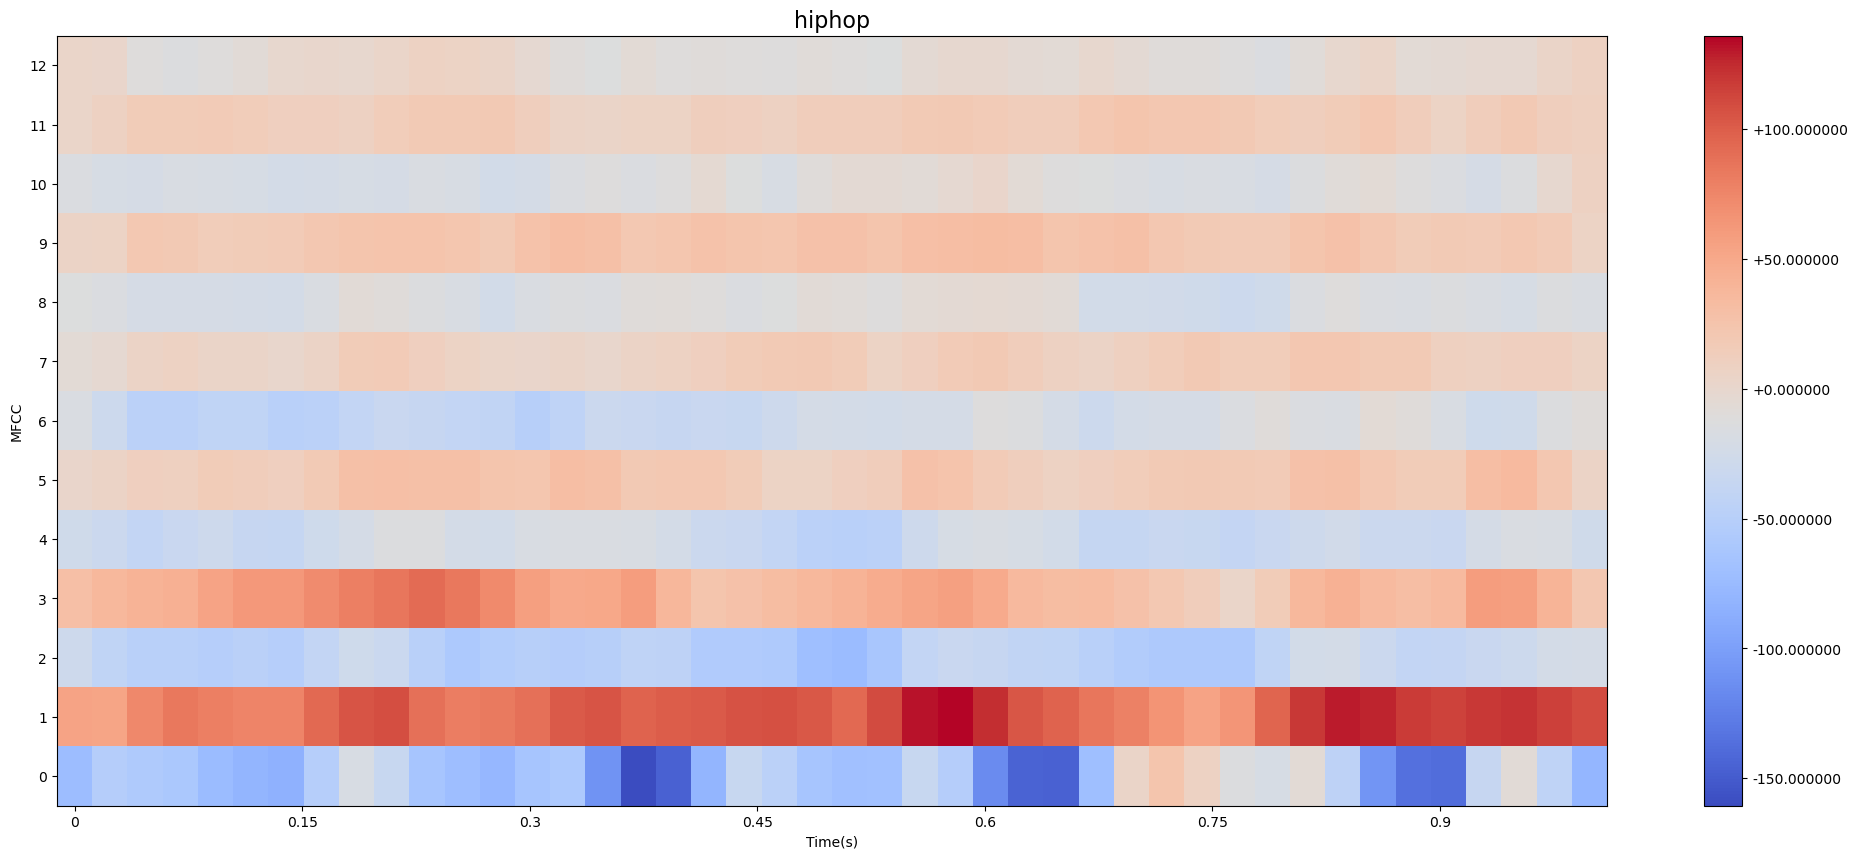

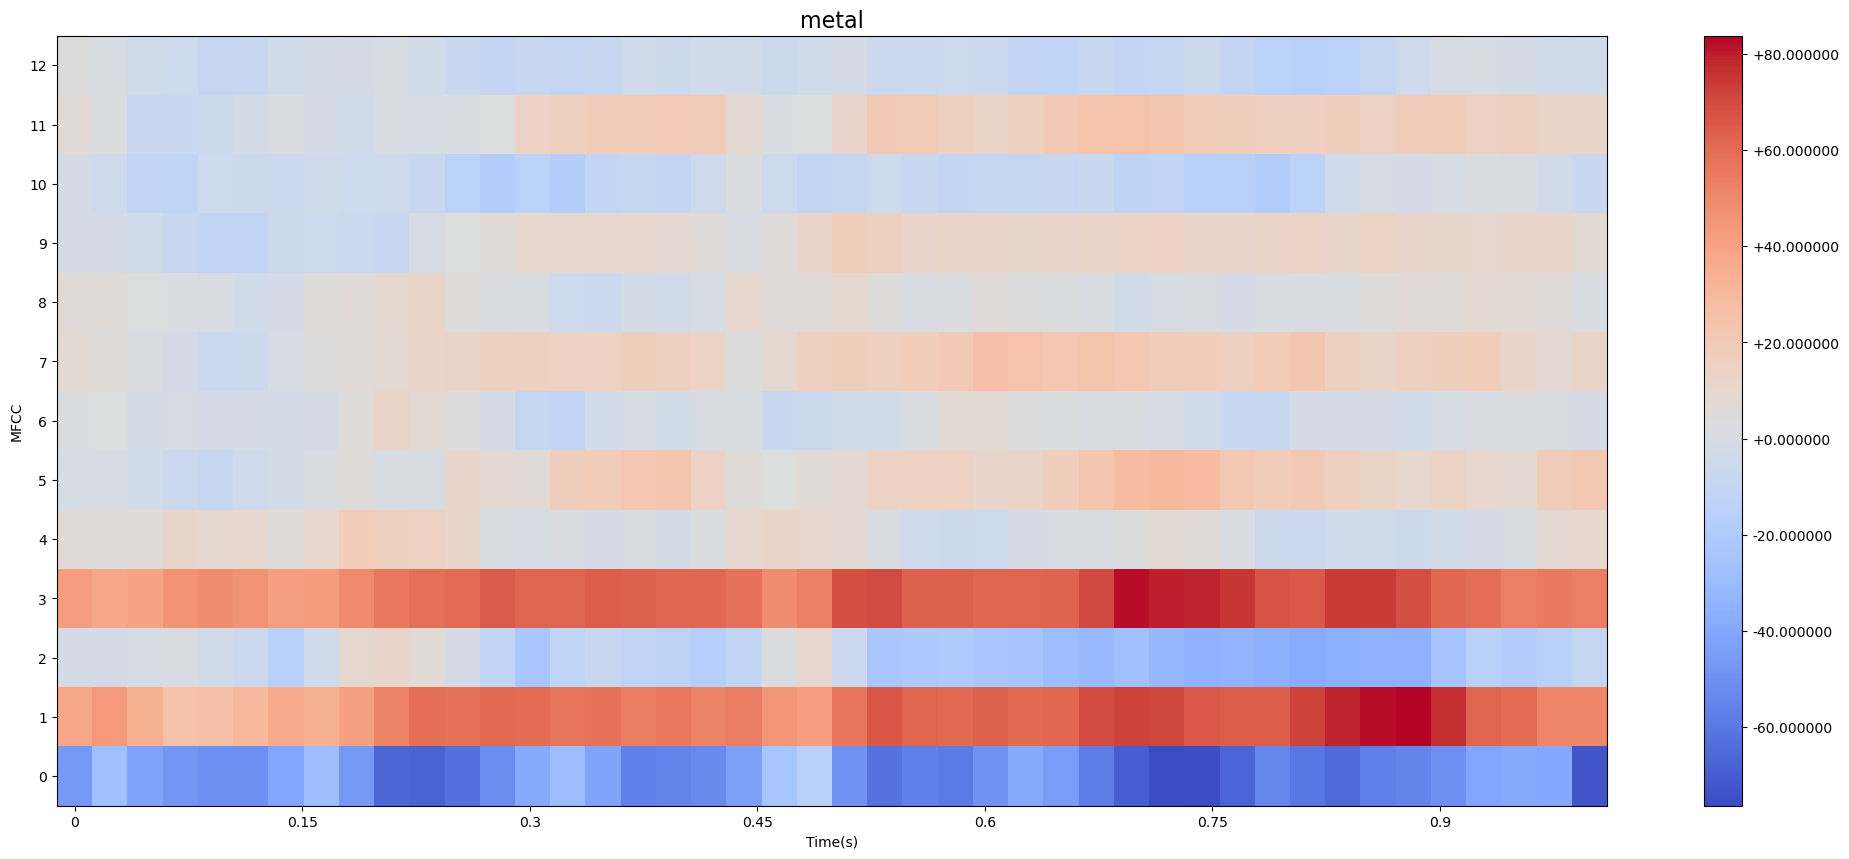

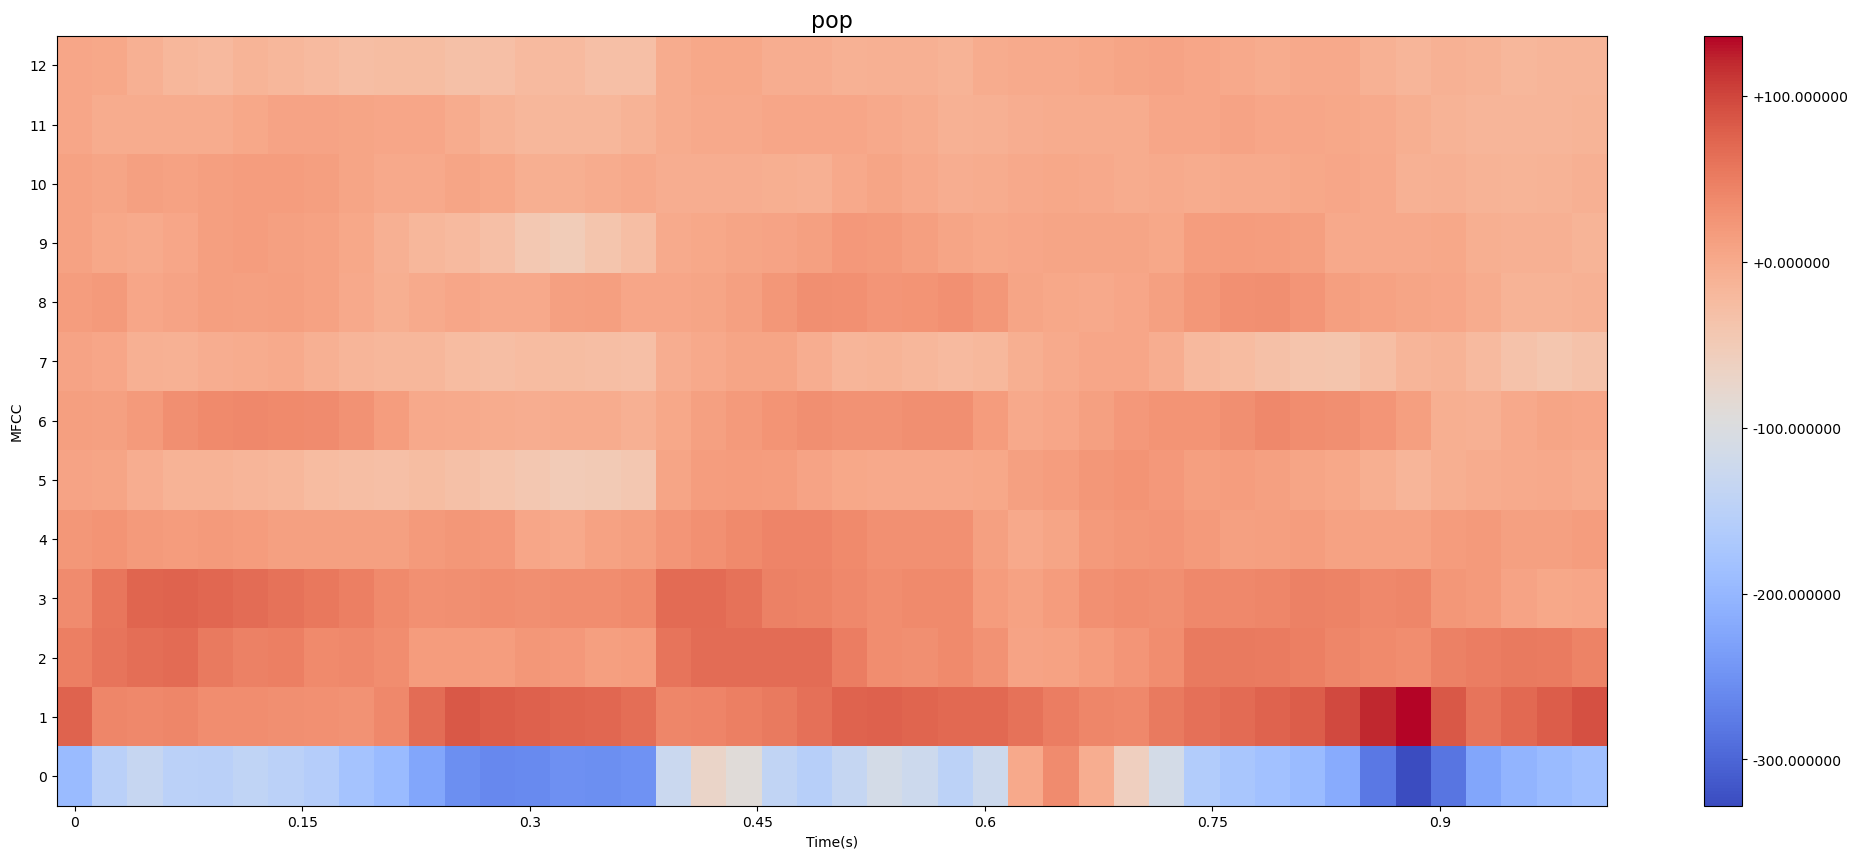

In [5]:
# Plot MFCC
for i in range(num_genres):
    plt.figure(figsize=(25,10))
    librosa.display.specshow(audio_mfcc[i][0],
                            x_axis='time',
                            sr=sr)
    plt.colorbar(format="%+2f")
    plt.xlabel('Time(s)')
    plt.ylabel('MFCC')
    plt.yticks(range(0, 13))
    plt.title(genre_names[i], fontsize=16)
    plt.show()

There are two points related to MFCC that should be mentioned:
- When calculating MFCCs, the frames used typically have some overlap to capture temporal information. This overlap allows for capture finer details of relationship between seprate frames.

- We use only first 12 or 13 MFCCs for two reason:
    - Reducing the dimensionality of our feature space. which reduce the time complexity.
    - In the process of creating MFCCs, we use Discrete Cosine Transform (DCT). One DCT properties is that it de-correlates and keeps most of the information in first few coefficients.

<a name='2-3'></a>
### <a id='toc3_3_'></a>Train Test Split [](#toc0_)
After extracting features, it is time to split the dataset into training data and test data and normalize them to achieve better results and faster convergence.

Additionally, we concatenate each part of the test data to create the actual test dataset.


In [7]:
# Hyper parameter
test_size = 0.98
music_len = 30

In [8]:
# Split data set to train data and test data
train_datas = np.empty((num_genres,), dtype=object)
test_datas = np.empty((num_genres,), dtype=object)
for i in range(num_genres):
    X = audio_mfcc[i]
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=42)
    train_datas[i] = normalize(np.concatenate(X_train, axis=1), axis=0)
    test_datas[i] = [normalize(test, axis=0) for test in X_test]

for i in range(num_genres):
    size = floor(num_files_per_genre * test_size)
    datas = np.empty((size, ), dtype=object)
    for j in range(size):
        if j != size - 1:
            datas[j] = np.concatenate(test_datas[i][j * music_len: (j + 1) * music_len], axis=1)
        else:
            datas[j] = np.concatenate(test_datas[i][j * music_len:], axis=1)
    test_datas[i] = datas


<a name='3'></a>
## <a id='toc4_'></a>Modeling by Use of HMM [](#toc0_)
An HMM defines by four parameter:
- `States`
- `Observations`
- `Transition Probabilities`
- `Emission Probabilities`

In this problem, each `state` specifies some features of the audio. It actually keeps track of more complex features than the initially calculated ones, and it is somehow a combination of them. The `observations` are the MFCCs that we extracted earlier.

`Transition Probabilities` and `Emission Probabilities` should be calculated by training our model.



<a name='3-1'></a>
### <a id='toc4_1_'></a>First Order HMM [](#toc0_)
In a first-order HMM, the probability of transitioning from one hidden state to another depends only on the current state and not on any previous states. It is named "first-order" because each state depends only on one state (the previous state). In other words, the next state is independent of all states given the current state.

In higher-order models, the transition probabilities are allowed to depend on multiple previous states.

 <a name='3-2'></a>
### <a id='toc4_2_'></a>Applications and Use Cases of HMMs [](#toc0_)

HMMs are particularly effective for modeling and analyzing sequential data in situations where the underlying system has unobserved or hidden states. This is because HMMs utilize states that are interconnected, and each state is associated with specific observations. The model is trained based on a sequence of observations(not only single observation), making it highly dependent on the order of the observation sequence.

Some application of HMM are as follows:
* Speech recognition
* Handwriting recognition
* Gene prediction


 <a name='3-3'></a>
### <a id='toc4_3_'></a>Advantages and Disadvantages [](#toc0_)
 **Advantages:**
 - Efficient algorithms-learning can take place from raw sequence data.
 - Can handle inputs of variable length.
 - HMMs are robust to noise and uncertainty, which is particularly useful in speech recognition where the quality of audio recordings can be poor.


 **Disadvantages:**
 - HMMs often have a large number of unstructured parameters.
 - HMMs may struggle to capture long-term dependencies in data due to the limited memory provided by the Markov assumption.



 <a name='3-4'></a>
### <a id='toc4_4_'></a>Different Types of HMM [](#toc0_)
Here are some different types of HMMs:
1. **Discrete HMM (DHMM)**:

    - In a Discrete HMM, both the hidden states and the observable outputs are
     discrete. This type of HMM is often used when dealing with categorical data.
2. **Continuous HMM (CHMM)**:
    - In a Continuous HMM, the observable outputs are continuous variables. This type of HMM is commonly employed in applications where the data is best represented by continuous values.
3. **Left-Right HMM:**
    - Left-Right HMMs are a specific type of HMM where transitions only occur from left to right in the state sequence. This structure is often used in modeling processes with a natural temporal order, such as speech signals.
4. **Factorial HMM (FHMM):**
    - FHMMs model dependencies among multiple sequences of observations. They are designed to capture interactions and correlations among different data streams.



<a name='4'></a>
## <a id='toc5_'></a>Implementation [](#toc0_)
We will follow two approaches: first, we will use the `hmmlearn` library, and in the second part, we will attempt to implement the algorithm ourselves.


<a name='4-1'></a>
### <a id='toc5_1_'></a>Implementing with Libraries [](#toc0_)
`lib_hmm_models` contains HMM models that have been trained on different classes of datasets. When we provide each model with an input, it gives us the likelihood of that input belonging to the class model.

In [9]:
# Hyper parameter
num_hidden_states = 5
music_len = 30

In [49]:
train_datas[0].T[0:2000].shape

(2000, 13)

In [69]:
# Train models
lib_hmm_models = np.empty((num_genres,), dtype=object)

for i in range(num_genres):
    lib_hmm_models[i] = GaussianHMM(n_components=num_hidden_states)
    lib_hmm_models[i].fit(train_datas[i].T)


For testing, we provide each model with an input, and the model that gives the maximum likelihood is considered the target class.

In [70]:
# Test models
lib_predictions = np.zeros((num_genres,), dtype=object)
accuracy = np.zeros((num_genres,))
for i in range(num_genres):
    predictions = np.zeros((len(test_datas[i],)))
    for k in range(len(test_datas[i])):
        score = np.zeros((num_genres,))
        for j in range(num_genres):
            score[j] = lib_hmm_models[j].score(test_datas[i][k].T)
        predictions[k] = np.argmax(score)
    lib_predictions[i] = predictions

<a name='4-2'></a>
### <a id='toc5_2_'></a>Implementing from Scratch [](#toc0_)
The `HMM` class implements the Gaussian HMM using the forward(`alpha`) and backward(`beta`) algorithms. At each level, it updates the `transition-matrix`, `mean`, and `covariances`. The `mean` and `covariances` are then used to update the emission probability(`B`).

In [120]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(1, self.num_hidden_states))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = self.initial_prob[:] * observation_matrix[:, t]
            else:
                alpha[:, t] = np.dot(alpha[:, t - 1], self.transition_matrix) * observation_matrix[:, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(observation_matrix[:, t + 1], self.transition_matrix) * beta[:, t + 1]
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            mean = self.mean[:, s]
            cov = self.covariances[:, :, s]
            B[s, :] = multivariate_normal.pdf(obs.T, mean=mean, cov=cov, allow_singular=True)

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self. _forward(B)

        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):

            partial_sum = (alpha[:, t] * self.transition_matrix.T).T * B[:, t + 1] * beta[:, t + 1]
            xi_sum += self._normalize(partial_sum)

            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)

        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)


        expected_prior = gamma[:, 0]

        gamma_sum = np.repeat(np.sum(xi_sum, axis=1)[:, np.newaxis], axis=1, repeats=self.num_hidden_states)
        expected_transition = self._stochasticize(xi_sum / gamma_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


Now let's iterate through each unique genre in the training data to train a separate model for each class.

In [121]:
# Train
scr_hmm_models = np.empty((num_genres,), dtype=object)

for i in range(num_genres):
    scr_hmm_models[i] = HMM(num_hidden_states=num_hidden_states)
    scr_hmm_models[i].train(train_datas[i], 10)

In [122]:
## Test
scr_predictions = np.zeros((num_genres,), dtype=object)
for i in range(num_genres):
    predictions = np.zeros((len(test_datas[i],)))
    for k in range(len(test_datas[i])):
        score = np.zeros((num_genres,))
        for j in range(num_genres):
            score[j] = scr_hmm_models[j].score(test_datas[i][k])
        predictions[k] = np.argmax(score)
    scr_predictions[i] = predictions

<a name='5'></a>
## <a id='toc6_'></a>Evaluation [](#toc0_)

<a name='5-1'></a>
### <a id='toc6_1_'></a>Classification Quality Metrics [](#toc0_)


<a name='5-1-1'></a>
#### <a id='toc6_1_1_'></a>Accuracy [](#toc0_)
**Accuracy** measures the proportion of correctly classified cases from the total number of objects in the dataset. To compute the metric, divide the number of correct predictions by the total number of predictions made by the model.

$$
    Accuracy = \frac{Correct \space Predictions}{All \space Predictions}
$$

**Accuracy is straightforward to interpret**, but while it does provide an estimate of the overall model quality, it disregards **class balance** and the **cost of different errors**.

<a name='5-1-2'></a>
#### <a id='toc6_1_2_'></a>Percision [](#toc0_)
**Precision for a given class** in multi-class classification is the fraction of instances correctly classified as belonging to a specific class out of all instances the model predicted to belong to that class.

$$
    Precision_{Class \space A} = \frac{TP_{Class \space A}}{TP_{Class \space A} + FP_{Class \space A}}
$$

where,

 * $ TP_{Class \space A}$: Number of instances that correctly predicted as Class "A"

 * $FP_{Class \ space A}$: Number of instances that wrongly predicted as Class "A"


<a name='5-1-3'></a>
#### <a id='toc6_1_3_'></a>Recall [](#toc0_)
 **Recall** in multi-class classification is the fraction of instances in a class that the model correctly classified out of all instances in that class.

 $$
        Recall_{Class \space A} = \frac{TP_{Class \space A}}{TP_{Class \space A} + FN_{Class \space A}}
 $$

where,
 * $FN_{Class \space A}$: Number instance in Calss "A" that wrongly predicted as another Class
<b>

    > **Compare Precision with Recall**
    <br>
    Precision aims to minimize false positive errors but does not consider false  negatives. In other words, it does not account for cases when we miss the    target event. On the other hand, Recall treats false negative errors as more   costly than false positives.
    <br>
    For example, consider a spam filter model with 100 emails, of which 40 are  spam. If we correctly predict one of the spam emails and predict all remaining   99 emails as non-spam, we get 100% precision, but the accuracy is only 61%! On    the other hand, if we predict all of them as spam, we get 100% recall, but the     accuracy drops to 40%.
    <br>
    It appears that we need to balance or maximize both precision and recall, or    choose one based on our specific goals and priorities.

<a name='5-1-4'></a>
#### <a id='toc6_1_4_'></a>F1 Score [](#toc0_)
**F1-score** is a metric which takes into account both precision and recall and is defined as follows:
<br>

$$
    F1 \space Score_{Class \space A} = 2 * \frac{Precision_{Class \space A} * Recall_{Class \space A}}{Precision_{Class \space A} + Recall_{Class \space A}} \quad ; \quad 0 \leq F1 \space Score \leq 1
$$
<br>

F1 Score becomes 1 only when precision and recall are both 1. F1 score becomes high only when both precision and recall are high. F1 score is the harmonic mean of precision and recall and is a better measure than accuracy.

> **Why Use Harmonic Mean For F1 Score?**
<br>
By definition the F1 score is a harmonic mean of percision and recall.
We use the harmonic mean instead of the simple average because it punishes extreme values and gives more weight to values that are smaller, which is important in cases where precision or recall are very low. And hence by using the harmonic meaning for F1 Score it becomes more appropriate for averaging ratios than the arithmetic mean.
<br>
For example suppose a classifier has a precison of $0.1$ and the recall of $0.9$ the arithmetic mean of these values will be $0.5$ which suggests that the classifier overal performance is kind of moderate. However the F1 score of the same classifire  will be $0.2$ which reflects the fact the low precison severly impactsthe overal performance of the classifier model.

<a name='5-2'></a>
### <a id='toc6_2_'></a>Averaging [](#toc0_)


<a name='5-2-1'></a>
#### <a id='toc6_2_1_'></a>Macro-averaging [](#toc0_)
Macro-averaging is computed as a simple arithmetic mean of our per-class metrics.



<a name='5-2-2'></a>
#### <a id='toc6_2_2_'></a>Micro-averaging [](#toc0_)
The formula for each metrics are as follows:
$$
    \text{Micro Precision} = \frac{\text{Net} \space TP}{\text{Net} \space TP + \text{Net} \space FP}
$$

<br>

$$
    \text{Micro Recall} = \frac{\text{Net} \space TP}{\text{Net} \space TP + \text{Net} \space FN}
$$

<br>

$$
    \text{Micro Precision} = \frac{\text{Net} \space TP}{\text{Net} \space TP + \frac{1}{2}(\text{Net} \space FP + \text{Net} \space FN)}
$$

It can be shown that:
$$
    \text{Micro Precision} = \text{Micro Recall} = \text{Micro Precision} = \text{Accuracy}
$$

<a name='5-2-3'></a>
#### <a id='toc6_2_3_'></a>Weighted-averaging [](#toc0_)
It is computed as a weighted arithmetic mean of our per-class metric, where the weight of each class equals the number of instances of that class divided by the total number of instances.

<a name='5-3'></a>
## <a id='toc7_'></a>View Results [](#toc0_)
The `Evaluation` class calculates all the mentioned metrics using the given formulas.

In [42]:
class Evaluation:
    def __init__(self, predictions, class_names):
        self.predictions = predictions
        self.class_names = class_names
        self.num_class = predictions.shape[0]
        self.num_instance = np.array([predictions[i].shape[0] for i in range(self.num_class)], dtype=int)

        self.precision = np.zeros((self.num_class,))
        self.recall = np.zeros((self.num_class,))
        self.f1_score = np.zeros((self.num_class,))

        self.accuracy = None
        self.avg_precision = dict()
        self.avg_recall = dict()
        self.avg_f1_score = dict()

    def _TP_plus_FP(self, cls):
        sum = 0
        for i in range(self.num_class):
            sum += np.count_nonzero(self.predictions[i] == cls)
        return sum

    def _accuracy(self):
        TP = 0
        for i in range(self.num_class):
            TP = TP + np.count_nonzero(self.predictions[i] == i)
        self.accuracy = TP / np.sum(self.num_instance)

    def _precision(self):
        for i in range(self.num_class):
            self.precision[i] = np.count_nonzero(self.predictions[i] == i) / self._TP_plus_FP(i)

    def _recall(self):
        for i in range(self.num_class):
            self.recall[i] = np.count_nonzero(self.predictions[i] == i) / self.num_instance[i]

    def _f1_score(self):
        self._precision()
        self._recall()
        self.f1_score = 2 * self.precision * self.recall / (self.precision + self.recall)

    def _avg_precision(self):
        if self.accuracy == None:
            self._accuracy()
        mean = np.mean(self.precision)
        self.avg_precision = {'macro':mean, 'micro':self.accuracy, 'weighted':mean}

    def _avg_recall(self):
        if self.accuracy == None:
            self._accuracy()
        mean = np.mean(self.recall)
        self.avg_recall = {'macro':mean, 'micro':self.accuracy, 'weighted':mean}

    def _avg_f1_score(self):
        if self.accuracy == None:
            self._accuracy()
        mean = np.mean(self.f1_score)
        self.avg_f1_score = {'macro':mean, 'micro':self.accuracy, 'weighted':mean}

    def evaluate(self):
        self._precision()
        self._recall()
        self._f1_score()
        self._avg_precision()
        self._avg_recall()
        self._avg_f1_score()

    def plt_confusion_matrix(self):
        true_labels = np.zeros((0,))
        for i in range(self.num_class):
            true_labels = np.concatenate((true_labels, i * np.ones((self.num_instance[i],))))

        cm = confusion_matrix(true_labels.flatten(), np.concatenate(self.predictions))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()

        label_pos = np.arange(self.num_class)
        plt.xticks(label_pos, self.class_names)
        plt.yticks(label_pos, self.class_names)

        thresh = cm.max() / 2.

        for i in range(self.num_class):
            for j in range(self.num_class):
                plt.text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')

    def show(self):
        avg_names = ['macro', 'micro', 'weighted']
        print("Class\t\tPrecision\tRecall\t\tF1-Score")
        print("--------------------------------------------------------")
        for i in range(self.num_class):
            print("{}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}".format(self.class_names[i], self.precision[i], self.recall[i], self.f1_score[i]))
        print("--------------------------------------------------------")
        for i in range(len(avg_names)):
            print("{}\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(avg_names[i] + ' avg', self.avg_precision[avg_names[i]],
                                                              self.avg_recall[avg_names[i]], self.avg_f1_score[avg_names[i]]))
        print("--------------------------------------------------------")
        print("{}\t{:.3f}".format('accuracy', self.accuracy))

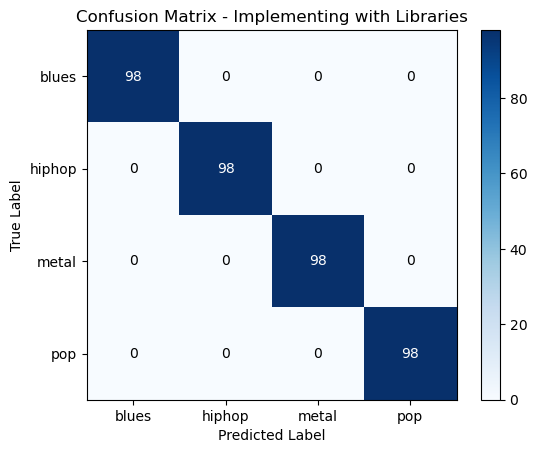

In [71]:
# Plot Confusion Matrix
lib_eval = Evaluation(lib_predictions, genre_names)
lib_eval.plt_confusion_matrix()
plt.title('Confusion Matrix - Implementing with Libraries')
print()

In [125]:
lib_eval.evaluate()
print("Implementing with Libraries:\n")
lib_eval.show()

Implementing with Libraries:

Class		Precision	Recall		F1-Score
--------------------------------------------------------
blues		1.00		1.00		1.00
hiphop		1.00		1.00		1.00
metal		1.00		1.00		1.00
pop		1.00		1.00		1.00
--------------------------------------------------------
macro avg	1.000		1.000		1.000
micro avg	1.000		1.000		1.000
weighted avg	1.000		1.000		1.000
--------------------------------------------------------
accuracy	1.000


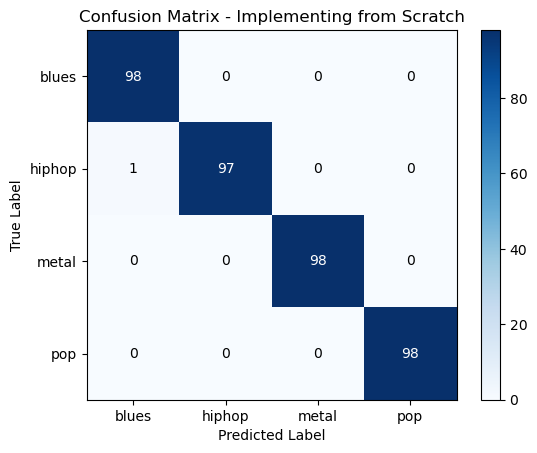

In [126]:
scr_eval = Evaluation(scr_predictions, genre_names)
scr_eval.plt_confusion_matrix()
plt.title('Confusion Matrix - Implementing from Scratch')
print()

In [127]:
scr_eval.evaluate()
print("Implementing from Scratch:\n")
scr_eval.show()

Implementing from Scratch:

Class		Precision	Recall		F1-Score
--------------------------------------------------------
blues		0.99		1.00		0.99
hiphop		1.00		0.99		0.99
metal		1.00		1.00		1.00
pop		1.00		1.00		1.00
--------------------------------------------------------
macro avg	0.997		0.997		0.997
micro avg	0.997		0.997		0.997
weighted avg	0.997		0.997		0.997
--------------------------------------------------------
accuracy	0.997


<a name='5-4'></a>
## <a id='toc8_'></a>Compare Results [](#toc0_)
In the first implementation, all test data predicted correctly, but there is some mispredictions in the second implementation although both implementations use the same model (Gaussian HMM). There could be several reasons for this discrepancy:

> 1. Libraries (in our case `hmmlearn`) may have additional preprocessing for the dataset beyond what we initially did at the beginning of the project.

> 2. There may be some differences in updating the values; it's possible that hmmlearn uses a different approach than what we implemented.

> 3. We do not ensure that our model will converge in the second part and just iterate for a known number($30$ times). It is possible that it hasn't converged yet.

<a name='6'></a>
## <a id='toc9_'></a>Refrences [](#toc0_)

* [Accuracy vs. precision vs. recall in machine learning: what's the difference?](https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall)
* [Accuracy, precision, and recall in multi-class classification](https://www.evidentlyai.com/classification-metrics/multi-class-metrics)
* [F1 Score in Machine Learning: Intro & Calculation](https://www.v7labs.com/blog/f1-score-guide)
* [Why we use harmonic mean for F1 score?](https://www.youtube.com/shorts/rZbSoZw4SCU)